In [1]:
%pip install transformers opencv-python datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 23.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [58]:
!unzip drive/MyDrive/archive.zip -d dataset

Archive:  drive/MyDrive/archive.zip
   creating: dataset/crackdataset/dataset/.ipynb_checkpoints/
   creating: dataset/crackdataset/dataset/predict/.ipynb_checkpoints/
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1134.JPG  
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1133.JPG  
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1129.JPG  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9642_10_12.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9299_7_12.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9178_9_18.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9221_6_11.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9115_9_10.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9720_11_4.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9620_8_11.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9146_9_9.jpg  
  inflati

In [7]:
from transformers import AutoImageProcessor, Swinv2ForImageClassification, TrainingArguments, Trainer, AutoConfig
from datasets import load_dataset, load_metric
from PIL import Image
import requests
import torch
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
metric = load_metric("accuracy")
metricp = load_metric("precision")
metricr = load_metric("recall")
metricf1 = load_metric("f1")
def compute_metrics(p):
    return {"accuracy":metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "precision":metricp.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "recall":metricr.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "f1":metricf1.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)}

In [36]:
dataset = load_dataset("imagefolder", data_dir="dataset/crackdataset/dataset/", drop_labels=False)

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-ee376b591340f6e7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

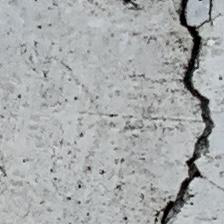

1

In [37]:
display(dataset['train'][-1]['image'])
dataset['train'][-1]['label']

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [39]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window16-256")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [40]:
transform = A.Compose([
    A.Resize(width=256, height=256, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 200.0), p=0.5),
    A.AdvancedBlur(blur_limit=(3, 7), p=0.5),
    # A.CLAHE(clip_limit=2.0, p=1)
])

In [41]:
# def transforms(examples):
#     examples["pixel_values"] = [transform(image=np.array(image))["image"] for image in examples["image"]]
#     return examples

def transform_and_extract(batch):
    inputs = feature_extractor(
        [transform(image=np.array(image))["image"] for image in batch["image"]],
        return_tensors='pt'
    )
    inputs['labels'] = batch['label']
    return inputs

In [42]:
dataset.set_transform(transform_and_extract)

In [43]:
img = dataset["train"][0]
img
# plt.imshow(img)
# plt.imshow(transform(image=np.array(Image.open('dataset/predict/IMG_1129.JPG')))["image"])

{'pixel_values': tensor([[[-1.9638, -1.8439, -1.4672,  ...,  0.6049,  0.6221,  0.6563],
          [-1.9295, -1.7583, -1.3302,  ...,  0.6049,  0.6049,  0.6221],
          [-1.8097, -1.5870, -1.1075,  ...,  0.6906,  0.6221,  0.6221],
          ...,
          [ 0.9817,  0.9303,  0.8276,  ...,  0.2111,  0.0741,  0.0741],
          [ 0.9646,  0.8961,  0.7933,  ...,  0.3481,  0.0741,  0.0227],
          [ 0.9474,  0.8789,  0.7933,  ...,  0.4337,  0.1254,  0.0227]],
 
         [[-1.8606, -1.7206, -1.3179,  ...,  0.8179,  0.8354,  0.8704],
          [-1.8256, -1.6331, -1.1779,  ...,  0.8004,  0.8004,  0.8354],
          [-1.6856, -1.4580, -0.9503,  ...,  0.8880,  0.8354,  0.8179],
          ...,
          [ 1.1856,  1.1331,  1.0455,  ...,  0.3627,  0.2227,  0.2227],
          [ 1.1681,  1.0980,  1.0105,  ...,  0.5028,  0.2227,  0.1702],
          [ 1.1506,  1.0980,  0.9930,  ...,  0.6078,  0.2752,  0.1702]],
 
         [[-1.6127, -1.4733, -1.0376,  ...,  1.1237,  1.1411,  1.1759],
          [-

In [44]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [45]:
metric = load_metric("accuracy")
metricp = load_metric("precision")
metricr = load_metric("recall")
metricf1 = load_metric("f1")
def compute_metrics(p):
    return {"accuracy":metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "precision":metricp.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "recall":metricr.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "f1":metricf1.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)}

In [46]:
labels = dataset['train'].features['label'].names

# config = AutoConfig.from_pretrained("microsoft/swinv2-base-patch4-window16-256")
# config.num_labels = len(labels)
# config.id2label = {str(i): c for i, c in enumerate(labels)}
# config.label2id = {c: str(i) for i, c in enumerate(labels)}
# model = Swinv2ForImageClassification.from_config(config)

model = Swinv2ForImageClassification.from_pretrained(
    "microsoft/swinv2-base-patch4-window16-256",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# out = model(torch.stack((dataset['train'][0]['pixel_values'],)).to(device))
# out.pooler_output.shape

In [48]:
training_args = TrainingArguments(
  output_dir="./swin-base-cracks",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [49]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [52]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 1200
})

In [53]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 300
  Number of trainable parameters = 86895866


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.065200,0.024236,{'accuracy': 0.99},{'precision': 0.9803921568627451},{'recall': 1.0},{'f1': 0.99009900990099}
200,0.000500,0.000669,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}
300,0.045800,0.000067,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}


***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Trainer is attempting to log a value of "{'accuracy': 0.99}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9803921568627451}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.99009900990099}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./swin-base-cracks/checkp

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 458239918GF
  train_loss               =      0.0487
  train_runtime            =  0:04:39.63
  train_samples_per_second =      17.165
  train_steps_per_second   =       1.073


In [55]:
metrics = trainer.evaluate(dataset['validation'])
trainer.log_metrics("eval", metrics['accuracy'])
trainer.save_metrics("eval", metrics['accuracy'])

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


Trainer is attempting to log a value of "{'accuracy': 1.0}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


KeyError: ignored

In [ ]:
metrics = trainer.evaluate(dataset['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

In [63]:
neg_image = Image.open('dataset/crackdataset/dataset/test/Negative/DJI_0669_14_9.jpg')
pos_image = Image.open('dataset/crackdataset/dataset/test/Positive/DJI_0677_14_17.jpg')
pred_image = Image.open('dataset/crackdataset/dataset/predict/sub/IMG_1129.JPG')
ex_features = feature_extractor([neg_image, pos_image, pred_image], return_tensors='pt')['pixel_values']
out = model(ex_features.to(device))
out.logits, torch.argmax(out.logits, dim=-1)

(tensor([[ 3.7082, -3.7331],
         [-5.4119,  5.2653],
         [ 2.9109, -3.0158]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([0, 1, 0], device='cuda:0'))

In [64]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [65]:
pytorch_total_params, pytorch_total_trainable_params

(86895866, 86895866)